In [1]:
import os
import torch
import torch.nn as nn
from models import AEEncoder, AEDecoder, SparseConvEncoder, SparseTConvEncoder, weights_init
import numpy as np
import h5py
from dataset import HRTFDataset, get_dataloaders
import global_params as gp
from utils import get_lsd, get_log_fft
import matplotlib.pyplot as plt

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using %s" % device)

Using cuda


In [3]:
# Initialize global parameters
aeExp = "exp1"
aeEp = "_ep123394.pth"
interpVer = "-6"
interpEp = "_ep2.pth"
nfft = 256

In [4]:
# Selecting region in the complete HRTF for linear interpolation
azNofSamples = gp.azOps[0]
azStart = gp.azOps[1]
elNofSamples = gp.elOps[0]
elStart = gp.elOps[1]

if gp.quadSelect == "full":
    azHopSize = int(np.floor(25/azNofSamples))
    elHopSize = int(np.floor(50/elNofSamples))

    if azStart >= azHopSize:
        print("Warning: Invalid value for azOps")
    if elStart > elHopSize:
        print("Warning: Invalid value for elOps")            

elif gp.quadSelect == "upper":
    azHopSize = int(np.floor(25/azNofSamples))
    elHopSize = int(np.float(33/elNofSamples))

    if azStart >= azHopSize:
        print("Warning: Invalid value for azOps")
    if elStart < 8 or elStart > 40 or elStart > elHopSize+8:
        print("Warning: Invalid value for elOps")

else:
    print("Warning: Invalid quadSelect selection")


if gp.samplingOp == "sym":
    azEnd = int((azNofSamples/2 - 1) * azHopSize) + azStart
    elEnd = int((elNofSamples/2 - 1) * elHopSize) + elStart

    azIndices = np.concatenate((np.arange(azStart, azEnd + 1, azHopSize), 
                                np.arange(24 - azEnd, 25 - azStart, azHopSize)))
    elIndices = np.concatenate((np.arange(elStart, elEnd + 1, elHopSize), 
                                np.arange(49 - elEnd, 50 - elStart, elHopSize)))
    
    azEnd = 25 - azStart + 1
    elEnd = 50 - elStart + 1
elif gp.samplingOp == "uni":
    azEnd = (azNofSamples-1)*azHopSize + azStart + 1
    elEnd = (elNofSamples-1)*elHopSize + elStart + 1

    azIndices = np.arange(azStart, azEnd, azHopSize)
    elIndices = np.arange(elStart, elEnd, elHopSize)

else:
    print("Warning: Invalid samplingOp selection")

azIndices = azIndices.reshape((azIndices.shape[0], 1))
elIndices = elIndices.reshape((1, elIndices.shape[0]))

azIndices = np.repeat(azIndices, elIndices.shape[1], axis=1)
elIndices = np.repeat(elIndices, azIndices.shape[0], axis=0)

In [5]:
azIndices

array([[ 4,  4,  4,  4,  4,  4],
       [12, 12, 12, 12, 12, 12],
       [20, 20, 20, 20, 20, 20]])

In [6]:
elIndices

array([[ 4, 12, 20, 28, 36, 44],
       [ 4, 12, 20, 28, 36, 44],
       [ 4, 12, 20, 28, 36, 44]])

In [7]:
print(azStart)
print(azEnd)
print(elStart)
print(elEnd)

4
21
4
45


In [8]:
if gp.interpEncoderOp == "conv":
    interpEncoder = SparseConvEncoder(inChannels=gp.inOutChannels, outChannels=gp.scOutChannels, 
                                      BNFlag=gp.scBNFlag, finalActType=gp.scFinalActType, 
                                      numConvBlocks=gp.scNumConvBlocks, kSizeArray=gp.scKSizeArray, 
                                      strideArray=gp.scStrideArray, padArray=gp.scPadArray, 
                                      dropoutP=gp.interpDropoutP).to(device)

elif gp.interpEncoderOp == "tconv":
    interpEncoder = SparseTConvEncoder(inChannels=gp.inOutChannels, outChannels=gp.stcOutChannels, 
                                       BNFlag=gp.stcBNFlag, finalActType=gp.stcFinalActType,
                                       numTConvBlocks=gp.stcNumTConvBlocks, kSizeArray=gp.stcKSizeArray, 
                                       strideArray=gp.stcStrideArray, padArray=gp.stcPadArray, 
                                       outPadArray=gp.stcOutPadArray, dropoutP=gp.interpDropoutP).to(device)

interpDecoder = AEDecoder(outChannels=gp.inOutChannels, finalActType=gp.decFinalActType, BNFlag=gp.decBNFlag, 
                          modelDepth=gp.modelDepth, featMapsMultFact=gp.featMapsMultFact, numConvBlocks=gp.numConvBlocks,
                          outPadArray=gp.decOutPadArray, dropoutP=gp.dropoutP).to(device)
aeEncoder = AEEncoder(inChannels=gp.inOutChannels, dsType=gp.encDSType, BNFlag=gp.encBNFlag,
                      modelDepth=gp.modelDepth, featMapsMultFact=gp.featMapsMultFact, numConvBlocks=gp.numConvBlocks,
                      dropoutP=gp.dropoutP).to(device)

aeDecoder = AEDecoder(outChannels=gp.inOutChannels, finalActType=gp.decFinalActType, BNFlag=gp.decBNFlag, 
                      modelDepth=gp.modelDepth, featMapsMultFact=gp.featMapsMultFact, numConvBlocks=gp.numConvBlocks,
                      outPadArray=gp.decOutPadArray, dropoutP=gp.dropoutP).to(device)

interpCheckpoint = torch.load("./saved_models/ft_resumed_interp_ae_"+aeExp+interpVer+interpEp, map_location=device)
aeCheckpoint = torch.load("./saved_models/resumed_ae_"+aeExp+aeEp, map_location=device)

interpEncoder.load_state_dict(interpCheckpoint['interpEncoder'])
if gp.interpDecTrainMode == "ft":
    interpDecoder.load_state_dict(interpCheckpoint['decoderFT'])
elif gp.interpDecTrainMode == "end2end":
    interpDecoder.load_state_dict(interpCheckpoint['interpDecoder'])


aeEncoder.load_state_dict(aeCheckpoint['encoder'])
aeDecoder.load_state_dict(aeCheckpoint['decoder'])

interpEncoder.eval()
interpDecoder.eval()
aeEncoder.eval()
aeDecoder.eval()

AEDecoder(
  (moduleDict): ModuleDict(
    (conv_first): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8)
    (tconv_2): ConvTranspose2d(128, 128, kernel_size=(2, 2), stride=(2, 2), output_padding=(0, 1), groups=8)
    (tconv_1): ConvTranspose2d(128, 128, kernel_size=(2, 2), stride=(2, 2), output_padding=(1, 0), groups=8)
    (final_conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8)
  )
  (firstConv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8)
  (tConvBlock): ConvTranspose2d(128, 128, kernel_size=(2, 2), stride=(2, 2), output_padding=(1, 0), groups=8)
  (finalConv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8)
  (finalAct): Sigmoid()
)

In [9]:
# Getting results on train dataset
# Get Data
datasetTrain = HRTFDataset(gp.dataPath, gp.whichHRIR, 
                           "train", gp.valSubjs, 
                           gp.anthroFlag, gp.anthroOp,
                           gp.azOps, gp.elOps, gp.samplingOp, gp.quadSelect)    
trainDL = get_dataloaders(datasetTrain, batchSize=datasetTrain.__len__())
for i, batch in enumerate(trainDL):
    inHRTF = batch["sparse_hrtf_l"].to(device)
    targetHRTF = batch["hrtf_l"].to(device)
    posArray = batch["pos_array"].to(device)
    
    # interp forward pass
    predHRTF = interpDecoder(interpEncoder(inHRTF))
        
    # vae forward pass
    latent = aeEncoder(targetHRTF)
    predAeHRTF = aeDecoder(latent)
    predFTAeHRTF = interpDecoder(latent)

In [10]:
targetHRTF = targetHRTF.detach().cpu()
predHRTF = predHRTF.detach().cpu()
predAeHRTF = predAeHRTF.detach().cpu()
predFTAeHRTF = predFTAeHRTF.detach().cpu()
inHRTF = inHRTF.detach().cpu()
predHRTF[:, :, azIndices, elIndices] = inHRTF

In [11]:
targetHRTF = 20*(targetHRTF - 1)*6
predHRTF = 20*(predHRTF - 1)*6
predAeHRTF = 20*(predAeHRTF - 1)*6
predFTAeHRTF = 20*(predFTAeHRTF - 1)*6
inHRTF = 20*(inHRTF - 1)*6

avgHRTF = torch.mean(targetHRTF, 0)
avgHRTFExpanded = avgHRTF.expand(targetHRTF.size()[0], targetHRTF.size()[1], 25, 50).clone()

In [12]:
azSize = targetHRTF.size()[2]
elSize = targetHRTF.size()[3]
linterpHRTF = nn.functional.interpolate(inHRTF, size=[azEnd-azStart, elEnd-elStart], mode='bilinear', align_corners=True)
avgHRTFExpanded[:, :, azStart:azEnd, elStart:elEnd] = linterpHRTF
linterpHRTF = avgHRTFExpanded
#linterpHRTF = avgHRTFExpanded
#linterpHRTF = nn.functional.interpolate(inHRTF, scale_factor=4, mode='bilinear')

In [13]:
lsdFreq = get_lsd(predHRTF[:, :, azStart:azEnd, elStart:elEnd], targetHRTF[:, :, azStart:azEnd, elStart:elEnd], "freq")
lsdFreqMean = torch.mean(lsdFreq, 0)

lsdFreqLinterp = get_lsd(linterpHRTF, targetHRTF, "freq")
lsdFreqLinterpMean = torch.mean(lsdFreqLinterp, 0)

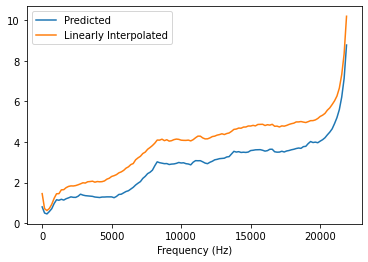

In [14]:
faxis = np.arange(nfft/2)*44100/nfft;
plt.plot(faxis, lsdFreqMean)
plt.plot(faxis, lsdFreqLinterpMean)
plt.xlabel("Frequency (Hz)")
plt.legend(["Predicted", "Linearly Interpolated"])

In [15]:
lsd = get_lsd(predHRTF, targetHRTF)
lsdMean = torch.mean(lsd)
print("Mean LSD: %.4f" % lsdMean)

lsdLinterp = get_lsd(linterpHRTF, targetHRTF)
lsdLinterpMean = torch.mean(lsdLinterp)
print("Mean LSD - Linearly Interpolated: %.4f" % lsdLinterpMean)

Mean LSD: 3.3151
Mean LSD - Linearly Interpolated: 3.7844


Text(0.5, 1.0, 'LSD : Predicted v/s Target')

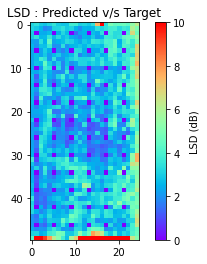

In [16]:
# Getting LSD plot
subj = 0
lsd2D = get_lsd(predHRTF, targetHRTF, mean_op="pos")
plt.imshow(lsd2D[subj].T, vmin=0, vmax=10, cmap='rainbow')
plt.colorbar(label="LSD (dB)", orientation="vertical")
plt.title("LSD : Predicted v/s Target")

In [17]:
lsd2D.size()
#posArray[0, 1, 0, 41]
#lsdLateral = lsd2D[:, :, [8, 40]]

torch.Size([42, 25, 50])

Text(0.5, 1.0, 'LSD : Linearly Interpolated v/s Target')

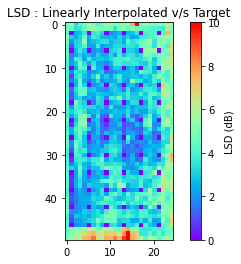

In [18]:
# Getting LSD plot for Linterp
lsd2D = get_lsd(linterpHRTF, targetHRTF, mean_op="pos")
plt.imshow(lsd2D[subj].T, vmin=0, vmax=10, cmap='rainbow')
plt.colorbar(label="LSD (dB)", orientation="vertical")
plt.title("LSD : Linearly Interpolated v/s Target")

Subject 6 LSD : 4.030
Subject 6 LSD : 4.528


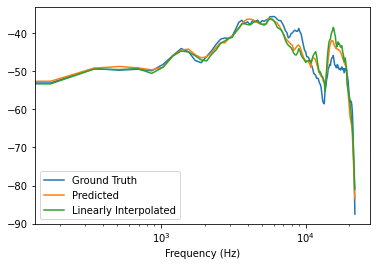

In [19]:
# Plotting hrtfs
subj = 6
az = 6
el = 18

thisLsd = lsd[subj]
print("Subject %d LSD : %.3f" % (subj, thisLsd))
thisLsdLinterp = lsdLinterp[subj]
print("Subject %d LSD : %.3f" % (subj, thisLsdLinterp))

thisTargetHrtf = targetHRTF[subj, :, az, el]
thisPredHrtf = predHRTF[subj, :, az, el]
thisLinterpHrtf = linterpHRTF[subj, :, az, el]

faxis = np.arange(nfft/2)*44100/nfft;
plt.plot(faxis, thisTargetHrtf)
plt.plot(faxis, thisPredHrtf)
plt.plot(faxis, thisLinterpHrtf)
plt.xscale("log")
plt.xlabel("Frequency (Hz)")
plt.legend(["Ground Truth", "Predicted", "Linearly Interpolated"])

In [9]:
# Getting results on Validation data

# Get Data
datasetVal = HRTFDataset(gp.dataPath, gp.whichHRIR, 
                         "val", gp.valSubjs, 
                         gp.anthroFlag, gp.anthroOp, 
                         gp.azOps, gp.elOps, gp.samplingOp, gp.quadSelect)
valDL = get_dataloaders(datasetVal, shuffle=False, batchSize=datasetVal.__len__())

for i, batch in enumerate(valDL):
    inHRTF = batch["sparse_hrtf_l"].to(device)
    targetHRTF = batch["hrtf_l"].to(device)
    posArray = batch["pos_array"].to(device)
    # interp forward pass
    predInterpEnc = interpEncoder(inHRTF)
    predHRTF = interpDecoder(predInterpEnc)
        
    # vae forward pass
    latent = aeEncoder(targetHRTF)
    predAeHRTF = aeDecoder(latent)
    predFTAeHRTF = interpDecoder(latent)

In [10]:
elAxis = posArray[0, 1, 12, :].cpu()
azAxis = [-80, -65, -55, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 55, 65, 80]

In [11]:
torch.amax(predInterpEnc)

tensor(1.4075, device='cuda:0', grad_fn=<AmaxBackward>)

In [12]:
targetHRTF = targetHRTF.detach().cpu()
predHRTF = predHRTF.detach().cpu()
predAeHRTF = predAeHRTF.detach().cpu()
predFTAeHRTF = predFTAeHRTF.detach().cpu()
inHRTF = inHRTF.detach().cpu()
predHRTF[:, :, azIndices, elIndices] = inHRTF

In [13]:
targetHRTF = 20*(targetHRTF - 1)*6
predHRTF = 20*(predHRTF - 1)*6
predAeHRTF = 20*(predAeHRTF - 1)*6
predFTAeHRTF = 20*(predFTAeHRTF - 1)*6
inHRTF = 20*(inHRTF - 1)*6

#avgHRTFBorder = avgHRTF.expand(targetHRTF.size()[0], targetHRTF.size()[1], 25, 50).clone()
#avgHRTFExpanded = avgHRTF.expand(targetHRTF.size()[0], targetHRTF.size()[1], 25, 50)

In [14]:
azSize = targetHRTF.size()[2]
elSize = targetHRTF.size()[3]
borderHRTF = torch.zeros(3, 128, 25, 50)
linterpHRTF = nn.functional.interpolate(inHRTF, size=[azEnd-azStart, elEnd-elStart], mode='bilinear', align_corners=True)
borderHRTF[:, :, azStart:azEnd, elStart:elEnd] = linterpHRTF
borderHRTF[:, :, :azStart, :] = borderHRTF[:, :, azStart, :][:, :, None, :]
borderHRTF[:, :, azEnd:, :] = borderHRTF[:, :, azEnd-1, :][:, :, None, :]
borderHRTF[:, :, :, :elStart] = borderHRTF[:, :, :, elStart][:, :, :, None]
borderHRTF[:, :, :, elEnd:] = borderHRTF[:, :, :, elEnd-1][:, :, :, None]
linterpHRTF = borderHRTF
#linterpHRTF = avgHRTFBorder
#linterpHRTF = nn.functional.interpolate(inHRTF, targetHRTF.size(), mode='bilinear')

In [15]:
linterpHRTF.size()

torch.Size([3, 128, 25, 50])

In [16]:
lsdFreq = get_lsd(predHRTF[:, :, azStart:azEnd, elStart:elEnd], targetHRTF[:, :, azStart:azEnd, elStart:elEnd], "freq")
lsdFreqMean = torch.mean(lsdFreq, 0)

lsdFreqLinterp = get_lsd(linterpHRTF[:, :, azStart:azEnd, elStart:elEnd], targetHRTF[:, :, azStart:azEnd, elStart:elEnd], "freq")
lsdFreqLinterpMean = torch.mean(lsdFreqLinterp, 0)

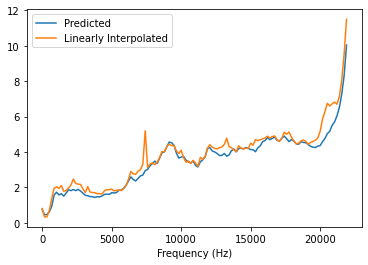

In [17]:
faxis = np.arange(nfft/2)*44100/nfft;
plt.plot(faxis, lsdFreqMean)
plt.plot(faxis, lsdFreqLinterpMean)
plt.xlabel("Frequency (Hz)")
plt.legend(["Predicted", "Linearly Interpolated"])

In [18]:
lsd = get_lsd(predHRTF, targetHRTF)
lsdMean = torch.mean(lsd)
print("Mean predicted LSD with extrapolation: %.5f" % lsdMean)

lsd = get_lsd(predHRTF[:, :, azStart:azEnd, elStart:elEnd], targetHRTF[:, :, azStart:azEnd, elStart:elEnd])
lsdMean = torch.mean(lsd)
print("Mean predicted LSD without extrapolation: %.5f" % lsdMean)

lsdLinterp = get_lsd(linterpHRTF, targetHRTF)
lsdLinterpMean = torch.mean(lsdLinterp)
print("Mean LSD - Linearly Interpolated with extrapolation: %.5f" % lsdLinterpMean)

lsdLinterp = get_lsd(linterpHRTF[:, :, azStart:azEnd, elStart:elEnd], targetHRTF[:, :, azStart:azEnd, elStart:elEnd])
lsdLinterpMean = torch.mean(lsdLinterp)
print("Mean LSD - Linearly Interpolated without extrapolation: %.5f" % lsdLinterpMean)

#lsdAvg = get_lsd(avgHRTFExpanded, targetHRTF)
#lsdAvgMean = torch.mean(lsdAvg)
#print("Mean LSD: Average %.5f" % lsdAvgMean)

lsdInterpAE = get_lsd(predHRTF, predAeHRTF)
lsdInterpAEMean = torch.mean(lsdInterpAE)
print("Mean LSD with respect to AE reconstruction : %.5f" % lsdInterpAEMean)

lsdFTAeAe = get_lsd(predFTAeHRTF, predAeHRTF)
lsdFTAeAeMean = torch.mean(lsdFTAeAe)
print("Mean LSD of AE reconstruction with finetuded decoder wrt to original AE reconstruction : %.5f" % lsdFTAeAeMean)

Mean predicted LSD with extrapolation: 4.11544
Mean predicted LSD without extrapolation: 3.60753
Mean LSD - Linearly Interpolated with extrapolation: 4.95146
Mean LSD - Linearly Interpolated without extrapolation: 3.94546
Mean LSD with respect to AE reconstruction : 3.26786
Mean LSD of AE reconstruction with finetuded decoder wrt to original AE reconstruction : 17.09728


In [19]:
lsd = get_lsd(predHRTF[:, :, azStart:azEnd, elStart:elEnd], targetHRTF[:, :, azStart:azEnd, elStart:elEnd], mean_op="pos")
lsdSTD = torch.std(lsd, dim=(0, 1, 2))
print("STD of predicted LSD: %.5f" % lsdSTD)

lsdLinterp = get_lsd(linterpHRTF[:, :, azStart:azEnd, elStart:elEnd], targetHRTF[:, :, azStart:azEnd, elStart:elEnd], mean_op="pos")
lsdLinterpSTD = torch.std(lsdLinterp)
print("STD of linterp LSD: %.5f" % lsdLinterpSTD)

STD of predicted LSD: 1.32301
STD of linterp LSD: 1.39237


In [20]:
lsd = get_lsd(predHRTF, targetHRTF, mean_op="pos")
lsdSTD = torch.std(lsd, dim=(0, 1, 2))
print("STD of predicted LSD: %.5f" % lsdSTD)

STD of predicted LSD: 1.75627


In [21]:
fMin = 0
fMax = 11000
lsdBL = get_lsd(predHRTF[:, :, azStart:azEnd, elStart:elEnd], targetHRTF[:, :, azStart:azEnd, elStart:elEnd], frange=[fMin, fMax])
lsdBLMean = torch.mean(lsdBL)
print("Mean Bandlimited LSD: %.3f" % lsdBLMean)

lsdBLLinterp = get_lsd(linterpHRTF, targetHRTF, frange=[fMin, 13000])
lsdBLLinterpMean = torch.mean(lsdBLLinterp)
print("Mean Bandlimited LSD - Linearly Interpolated: %.4f" % lsdBLLinterpMean)

Mean Bandlimited LSD: 2.339
Mean Bandlimited LSD - Linearly Interpolated: 3.7506


LSD for this subject: 3.62875


Text(0, 0.5, 'Elevation (deg)')

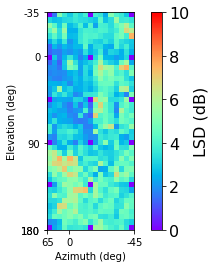

In [22]:
subj = 1
lsd2D = get_lsd(predHRTF[:, :, azStart:azEnd, elStart:elEnd], targetHRTF[:, :, azStart:azEnd, elStart:elEnd], mean_op="pos")
#lsd2D = get_lsd(predHRTF, targetHRTF, mean_op="pos")
print("LSD for this subject: %.5f" % torch.mean(lsd2D[subj]))
fig, ax = plt.subplots()
c = ax.imshow(lsd2D[subj].T, vmin=0, vmax=10, cmap='rainbow', interpolation="nearest", extent=[azStart, azEnd-1, elStart, elEnd-1])
plt.rcParams.update({'font.size': 16})
ax.set_yticks([elStart, 8-elStart, 24-elStart, 40-elStart, elEnd-1])
#ax.set_yticklabels([202.5, 180, 90, 0, -22.5])
ax.set_yticklabels([215, 180, 90, 0, -35])
ax.set_xticks([azStart, 12-azStart, azEnd-1])
#ax.set_xticklabels([40, 0, -40])
ax.set_xticklabels([65, 0, -45])
plt.colorbar(c, label="LSD (dB)", orientation="vertical")
plt.xlabel("Azimuth (deg)")
plt.ylabel("Elevation (deg)")
#plt.title("LSD : CNN predicted v/s Input")
#plt.savefig("../smc_figures/smc_interp_lsd_sp1_sub"+str(subj)+".pdf", bbox_inches="tight")

LSD linterp for this subject: 3.90322


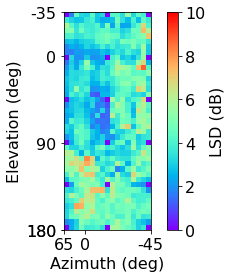

In [23]:
lsd2D = get_lsd(linterpHRTF[:, :, azStart:azEnd, elStart:elEnd], targetHRTF[:, :, azStart:azEnd, elStart:elEnd], mean_op="pos")
#lsd2D = get_lsd(linterpHRTF, targetHRTF, mean_op="pos")
print("LSD linterp for this subject: %.5f" % torch.mean(lsd2D[subj]))
fig, ax = plt.subplots()
c = ax.imshow(lsd2D[subj].T, vmin=0, vmax=10, cmap='rainbow', interpolation="nearest", extent=[azStart, azEnd-1, elStart, elEnd-1])
ax.set_yticks([elStart, 8-elStart, 24-elStart, 40-elStart, elEnd-1])
#ax.set_yticklabels([202.5, 180, 90, 0, -22.5])
ax.set_yticklabels([215, 180, 90, 0, -35])
ax.set_xticks([azStart, 12-azStart, azEnd-1])
#ax.set_xticklabels([40, 0, -40])
ax.set_xticklabels([65, 0, -45])
plt.colorbar(c, label="LSD (dB)", orientation="vertical")
plt.xlabel("Azimuth (deg)")
plt.ylabel("Elevation (deg)")
#plt.title("LSD : CNN predicted v/s Input")
plt.rcParams.update({'font.size': 16})
plt.savefig("../smc_figures/smc_Linterp_noextrap_lsd_sp2_sub"+str(subj)+".pdf", bbox_inches="tight")

LSD for this subject: 4.19575


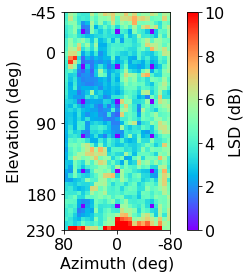

In [24]:
subj = 1
#lsd2D = get_lsd(predHRTF[:, :, azStart:azEnd, elStart:elEnd], targetHRTF[:, :, azStart:azEnd, elStart:elEnd], mean_op="pos")
lsd2D = get_lsd(predHRTF, targetHRTF, mean_op="pos")
print("LSD for this subject: %.5f" % torch.mean(lsd2D[subj]))
fig, ax = plt.subplots()
c = plt.imshow(lsd2D[subj].T, vmin=0, vmax=10, cmap='rainbow', interpolation="nearest", extent=[0, 24, 0, 49])
ax.set_yticks([0, 8, 24, 40, 49])
ax.set_yticklabels([230, 180, 90, 0, -45])
ax.set_xticks([0, 12, 24])
ax.set_xticklabels([80, 0, -80])
plt.colorbar(c, label="LSD (dB)", orientation="vertical")
plt.xlabel("Azimuth (deg)")
plt.ylabel("Elevation (deg)")
#plt.title("LSD : CNN predicted v/s Input")
plt.rcParams.update({'font.size': 16})
plt.savefig("../smc_figures/smc_interp_lsd_sp1_sub"+str(subj)+".pdf", bbox_inches="tight")

LSD linterp for this subject: 5.15308


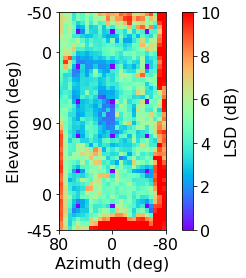

In [25]:
#lsd2D = get_lsd(linterpHRTF[:, :, azStart:azEnd, elStart:elEnd], targetHRTF[:, :, azStart:azEnd, elStart:elEnd], mean_op="pos")
lsd2D = get_lsd(linterpHRTF, targetHRTF, mean_op="pos")
print("LSD linterp for this subject: %.5f" % torch.mean(lsd2D[subj]))
fig, ax = plt.subplots()
c = plt.imshow(lsd2D[subj].T, vmin=0, vmax=10, cmap='rainbow', interpolation="nearest", extent=[0, 24, 0, 49])
ax.set_yticks([0, 8, 24, 40, 49])
ax.set_yticklabels([-45, 0, 90, 0, -50])
ax.set_xticks([0, 12, 24])
ax.set_xticklabels([80, 0, -80])
plt.colorbar(c, label="LSD (dB)", orientation="vertical")
plt.xlabel("Azimuth (deg)")
plt.ylabel("Elevation (deg)")
#plt.title("LSD : CNN predicted v/s Input")
plt.rcParams.update({'font.size': 16})
plt.savefig("../smc_figures/smc_Linterp_lsd_sp1_sub"+str(subj)+".pdf", bbox_inches="tight")

LSD for this subject: 4.76752


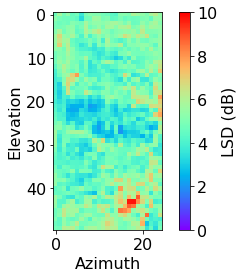

In [33]:
lsd2D = get_lsd(avgHRTFExpanded, targetHRTF, mean_op="pos")
print("LSD for this subject: %.5f" % torch.mean(lsd2D[subj]))
plt.imshow(lsd2D[subj].T, vmin=0, vmax=10, cmap='rainbow')
plt.colorbar(label="LSD (dB)", orientation="vertical")
plt.xlabel("Azimuth")
plt.ylabel("Elevation")
plt.rcParams.update({'font.size': 16})
#plt.title("LSD : Linearly Interpolated v/s Input")
plt.savefig("../smc_figures/smc_avg_lsd_sp2_sub"+str(subj)+".pdf", bbox_inches="tight")

In [34]:
torch.mean(lsd2D[subj])

tensor(4.7675)

Text(0.5, 1.0, 'LSD : Average HRTF v/s Input')

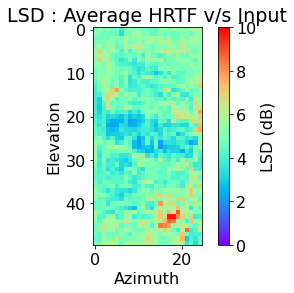

In [35]:
lsd2D = get_lsd(avgHRTFExpanded, targetHRTF, mean_op="pos")
plt.imshow(lsd2D[subj].T, vmin=0, vmax=10, cmap='rainbow')
plt.colorbar(label="LSD (dB)", orientation="vertical")
plt.xlabel("Azimuth")
plt.ylabel("Elevation")
plt.title("LSD : Average HRTF v/s Input")

Subject 2 LSD : 3.773
Subject 2 LSD : 4.448


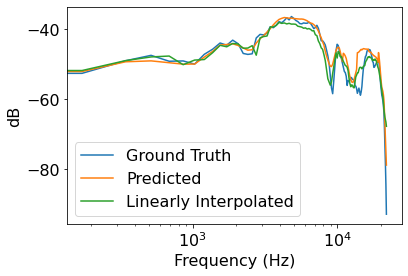

In [36]:
# Plotting hrtfs
subj = 2
az = 8
el = 14

thisLsd = lsd[subj]
print("Subject %d LSD : %.3f" % (subj, thisLsd))
thisLsdLinterp = lsdLinterp[subj]
print("Subject %d LSD : %.3f" % (subj, thisLsdLinterp))

thisTargetHrtf = targetHRTF[subj, :, az, el]
thisPredHrtf = predHRTF[subj, :, az, el]
thisLinterpHrtf = linterpHRTF[subj, :, az, el]

faxis = np.arange(nfft/2)*44100/nfft;
plt.plot(faxis, thisTargetHrtf)
plt.plot(faxis, thisPredHrtf)
plt.plot(faxis, thisLinterpHrtf)
plt.xscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("dB")
plt.legend(["Ground Truth", "Predicted", "Linearly Interpolated"])
#plt.savefig("./plots/test_ae_hrtfs.png")